# AI4Good -- OCR-Challenge
## Handwritten clinical records for Optical Character Recognition
This is an optical character recognition (OCR) challenge given as part of AI4good hackathon-2019 https://ai4good-montreal.devpost.com/. 
<img src="figures/gallery.jpg">

The goal is to built a neural network that transforms a picture of handwritten numbers into digitized text.
The model is a custom CNN-RNN-CTC model, inspirede by https://keras.io/examples/image_ocr/ and built from scratch in Keras. The model uses a VGG as feature extractor, which feeds to the bidirectional LSTM layers.

In [1]:
import cv2
import pandas as pd
from pathlib import Path
import numpy as np
import random
import imutils
import shutil
import zipfile


import matplotlib.pyplot as plt
%matplotlib inline


from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Activation, Reshape, Lambda, BatchNormalization
from keras.layers.merge import add, concatenate
from keras.optimizers import Adadelta
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.preprocessing.image import img_to_array
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


## Dataset
Load a dataset as a pandas dataframe

In [2]:
# Unzip the file
with zipfile.ZipFile("cell_images.zip","r") as zip_ref:
    zip_ref.extractall()

In [3]:
train_annotations_path = Path("cell_images/train.txt")
train_images_path = Path("cell_images/train")

train_df = pd.read_csv(train_annotations_path, sep=';')
print(train_df.info())
print()
print(train_df.head())
print()
print('Number of images = {}'.format(len(train_df)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 2 columns):
filename    7497 non-null object
value       7497 non-null object
dtypes: object(2)
memory usage: 117.2+ KB
None

  filename   value
0    1.jpg      97
1    2.jpg      18
2    3.jpg      56
3    4.jpg  10.200
4    5.jpg       9

Number of images = 7497


Value: 97


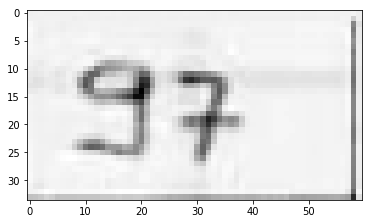

In [4]:
# create {image name: value} dictionary
train_images_names_values = {name: value for name, value in zip(list(train_df.filename), list(train_df.value))}
# create a list of images paths
train_imagesPathsList = [str(path) for path in train_images_path.glob('*.jpg')]

# Show image example
name = train_imagesPathsList[0].split('\\')[-1]
value = train_images_names_values[name]
img=cv2.imread(train_imagesPathsList[0], 0)
plt.imshow(img, cmap='Greys_r')
print('Value:',value)

## Data augmentation
To clean images, we remove the lines apparing in the borders of each image, binarize and rotate it. One could do a data augmentation by keras ImageDataGenerator module https://keras.io/preprocessing/image/ but it is not necessary in a first time.

value: 97


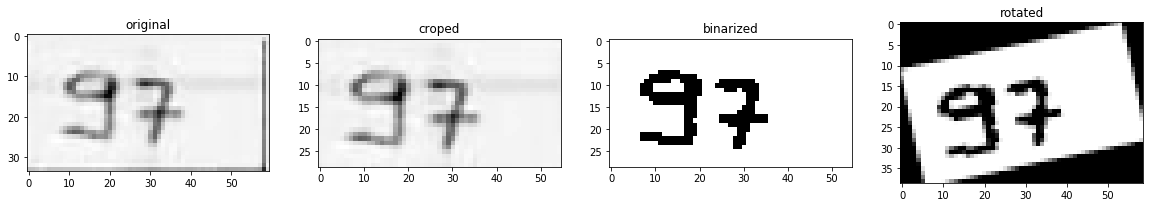

In [5]:
# Show the first processed image in train Folder with 3 kinds of transformations
name = train_imagesPathsList[0].split('\\')[-1]
value = train_images_names_values[name]


# original
original = cv2.imread(train_imagesPathsList[0], 0)
# croped
croped = original[2:original.shape[0]-3, 2:original.shape[1]-3]
# binarized
binarized = cv2.threshold(croped, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
# rotated
angle = 0
while angle == 0:
    angle = random.randint(-15,15)
rotated = imutils.rotate_bound(binarized, angle)


plt.figure(figsize=(20,5))
plt.subplot(1,4, 1)
plt.imshow(original, cmap='Greys_r')
plt.title('original')
plt.subplot(1,4, 2)
plt.imshow(croped, cmap='Greys_r')
plt.title('croped')
plt.subplot(1,4, 3)
plt.imshow(binarized, cmap='Greys_r')
plt.title('binarized')
plt.subplot(1,4, 4)
plt.imshow(rotated, cmap='Greys_r')
plt.title('rotated')


print('value:', value)

## Create train and validation datasets
We create a train and validation dataset. We split our original data into two new folders: data/train (90% images) and data/validation (10% images).

In [6]:
imagesFolder = 'data'
trainFolder = 'data/train'
valFolder = 'data/validation'

# if not created befor, create ...
if not Path(imagesFolder).is_dir():
    
    Path(imagesFolder).mkdir(parents=True, exist_ok=True)
    

    for src in train_imagesPathsList:
    
        # read image as grayscale
        img0 = cv2.imread(src, 0)
        # crop the image to remove staight lines in left and bottom sides
        img0 = img0[2:img.shape[0]-3, 2:img.shape[1]-3]
        # convert to binary image with threshold
        new_img = cv2.threshold(img0, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        
        angle = 0
        while angle == 0:
            angle = random.randint(-15,15)
        new_img_rotated = imutils.rotate_bound(new_img, angle)
        
        # get the image name
        name = src.split('\\')[-1]
        # get the value of the image
        number = train_images_names_values[name]

        # create new name including the value of image
        new_name1 = name.replace('.jpg', 'Z' + number + '.jpg')
        new_name2 = name.replace('.jpg', 'RZ' + number + '.jpg')

        
        dst1 = Path(imagesFolder) / new_name1
        dst2 = Path(imagesFolder) / new_name2
       

        # write the image
        cv2.imwrite(str(dst1), new_img)
        cv2.imwrite(str(dst2), new_img_rotated)
        
    totalImagesList = [str(path) for path in Path(imagesFolder).glob('*.jpg')]
    nbr_images = len(totalImagesList)
    random.shuffle(totalImagesList)
    
    Path(trainFolder).mkdir(parents=True, exist_ok=True)
    Path(valFolder).mkdir(parents=True, exist_ok=True)
    
    nbr_train = int(nbr_images * 0.9)
    nbr_validation = nbr_images - nbr_train
    
    for i, src in enumerate(totalImagesList):
        if i < nbr_train:
            dst = src.replace('data', 'data/train')
        else:
            dst = src.replace('data', 'data/validation')
            
        shutil.move(src, dst)  
else:
    pass

## Define the labels

In [7]:
listOfValues = list(train_df.value)
lenghtOfValues = [len(item) for item in listOfValues]
print('{} <= length of sentence <= {}'.format(min(lenghtOfValues), max(lenghtOfValues)))

# we choose the maximmum length of output sentence as
max_text_len = max(lenghtOfValues) + 2

# Find all inique characters in annotations of the dataset
charactersList = sorted(set(''.join(listOfValues)))
print('Unique characters apparing in images:', charactersList)

# define characters as string 
letters = ''.join(charactersList)
print('letters:', letters)


# The number of classes
num_classes = len(letters)
print('Number of classes is ',num_classes)

1 <= length of sentence <= 8
Unique characters apparing in images: ['-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
letters: -.0123456789
Number of classes is  12


## Helper functions

In [8]:
# Two functions to map any text to the labeles (letters)
def text_to_labels(text):
    # maping: "0123456789.-"  ==> [0,1,..., 11] 
    return list(map(lambda x: letters.index(x), text))

def labels_to_text(labels):
    # maping: [0,1,..., 11]  ==> "0123456789.-" 
    ret = []
    for c in labels:
        if c == len(letters):  # CTC Blank
            ret.append("")
        else:
            ret.append(letters[c])
    return "".join(ret)

In [9]:
def decode_predict_ctc(out, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        lables = K.get_value(K.ctc_decode(out, input_length=np.ones(out.shape[0])*out.shape[1],
                           greedy=False, beam_width=beam_width, top_paths=top_paths)[0][i])[0]
        text = labels_to_text(lables)
        results.append(text)
    return results

## Model architecture

The model input is image data, and we first feed the data to two convolutional networks to extract the image features, followed by the Reshape and Dense to reduce the dimensions of the feature vectors before letting the bidirectional LSTM process the sequential data. The sequential data feed to the LSTM is the horizontally divided image features. The final output Dense layer transforms the output for a given image to an array with the shape of (32, 13) representing (#of horizontal steps, #char labels).

The architecture of the model is as follow:

- build a Convolutional Neural Networks (CNN) to extract features from image.
- pass the the features to Recurrent neural network (RNN) layers based on Long Short Term Memory (LSTM) cells to encode the meaning of each windows
- feed a Connectionist Temporal Classification (CTC) with LSTM results to decode each image

<img src="figures/fig1.jpg">
Note: One could use GRU of keras https://keras.io/layers/recurrent/ instead LSTM

In [10]:
# Create the model
def get_model(training,img_w,img_h,num_classes,max_text_len):
    
    # Architecture of extractor
    def extractor(inputs):

        # Convolution layer (VGG)
        inner = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(inputs)
        inner = BatchNormalization()(inner)
        inner = Activation('relu')(inner)
        inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  

        inner = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
        inner = BatchNormalization()(inner)
        inner = Activation('relu')(inner)
        inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)

        inner = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner) 
        inner = BatchNormalization()(inner)
        inner = Activation('relu')(inner)
        inner = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)  
        inner = BatchNormalization()(inner)
        inner = Activation('relu')(inner)
        inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)  

        inner = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(inner)
        inner = BatchNormalization()(inner)
        inner = Activation('relu')(inner)
        inner = Conv2D(512, (3, 3), padding='same', name='conv6')(inner)  
        inner = BatchNormalization()(inner)
        inner = Activation('relu')(inner)
        inner = MaxPooling2D(pool_size=(1, 2), name='max4')(inner)  

        inner = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(inner)  
        inner = BatchNormalization()(inner)
        inner = Activation('relu')(inner)

        return inner
    
    # Forward and backward lstm architecture
    def bilstm(inner, name):
        name1 = name
        name2 = name + 'b'
        lstm = LSTM(256, return_sequences=True, kernel_initializer='he_normal', name=name1)(inner)  
        lstm_b = LSTM(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name=name2)(inner)
        reversed_lstm = Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1)) (lstm_b)

        return lstm, reversed_lstm
    
    # CTC lambda function
    def ctc_lambda_func(args):
        y_pred, labels, input_length, label_length = args
        y_pred = y_pred[:, :, :]
        return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


    # CTC loss function
    def ctc(max_text_len, y_pred):
        labels = Input(name='the_labels', shape=[max_text_len], dtype='float32')
        input_length = Input(name='input_length', shape=[1], dtype='int64') 
        label_length = Input(name='label_length', shape=[1], dtype='int64')

        # Keras doesn't currently support loss funcs with extra parameters
        # so CTC loss is implemented in a lambda layer
        loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

        return loss_out, labels, input_length, label_length

    # create the inputs
    inputs = Input(name='the_input', shape=(img_w, img_h, 1), dtype='float32')  
    
    # extractor layers
    inner = extractor(inputs)
    
    # Reshape + Dense, to connecte the extractor to RNN
    inner = Reshape(target_shape=((32, 2048)), name='reshape')(inner)  
    inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner) 

    # RNN layers
    
    # First bilstm with BatchNorm
    lstm_1, reversed_lstm_1b = bilstm(inner, 'lstm_1')
    inner = add([lstm_1, reversed_lstm_1b])
    inner = BatchNormalization()(inner)
    
    # Second bilstm with BatchNorm
    lstm_2, reversed_lstm_2b = bilstm(inner, 'lstm_2')
    inner = concatenate([lstm_2, reversed_lstm_2b])
    inner = BatchNormalization()(inner)

    # Dense + softmax activation, to bring the 32 prediction
    inner = Dense(num_classes + 1, kernel_initializer='he_normal',name='dense2')(inner) 
    y_pred = Activation('softmax', name='softmax')(inner)

    # CTC
    loss_out, labels, input_length, label_length = ctc(max_text_len, y_pred)
    
    
    
    if training:
        model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)
        model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adadelta(), metrics=['accuracy'])
    else:
        model = Model(inputs=[inputs], outputs=y_pred)
        
    return model



## Batch generator

In [11]:
class MyGenerator:
    '''
    This is the generator to create batch from a dataset
    max_text_len: the length of output sentence
    downsample_factor: reduce factor (timesteps = imag_h / downsample_factor)
    '''
    
    max_text_len = None
    downsample_factor = None
    
    def __init__(self,folder,batchSize):
        self.batchSize = batchSize
        self.imgPaths=[str(path) for path in Path(folder).glob('*.jpg')]
        self.length = len(self.imgPaths)
        
    def next_batch(self):
        while 1:
            x_batch      = []
            y_batch      = np.ones([self.batchSize, max_text_len]) * -1
            input_length = np.zeros([self.batchSize, 1])
            label_length = np.zeros([self.batchSize, 1])
            labels_batch = []
            for i in range(self.batchSize):
                imgpath=self.imgPaths[random.randint(0,self.length-1)]
                imgname = imgpath.split('Z')[-1][:-4]


                img=cv2.imread(imgpath,0)
                img=cv2.resize(img,(128,64))
                img=img_to_array(img)
                img = (img / 255.0) * 2.0 - 1.0

                input_length[i]=np.array(img).shape[1]//downsample_factor
                labels_batch.append(imgname)
                label_length[i]=len(imgname)

                x_batch.append(img)
                y_batch[i,0:len(imgname)]=text_to_labels(imgname)

            x_batch = np.array(x_batch, dtype="float")
            x_batch= x_batch.swapaxes(1,2)

            inputs = {'the_input': x_batch,
                      'the_labels': y_batch,
                      'input_length': input_length,
                      'label_length': label_length 
                      }
            outputs = {'ctc': np.zeros([self.batchSize])}  
            yield (inputs,outputs)
        

## Training

In [12]:
# Parameters
img_w,img_h = 128,64 # image shape
training = True #  True for training
batchSize=128 # the batch size for train an validation
epochs= 150 # number of epochs
downsample_factor=4




# create model 
model = get_model(training,img_w,img_h,num_classes,max_text_len)

# Show the architecture of the model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 64)  640         the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 64, 64)  256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 64, 64)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max1 (MaxP

In [13]:
# Train the model

# create a folder to save the final model
modelsFolder = "models"
Path(modelsFolder).mkdir(parents=True, exist_ok=True)

modelFileName="best_weights.hdf5" # name of model weights
filepath = str(Path(modelsFolder) / modelFileName)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,  period=1, mode='min')

MyGenerator.max_text_len = max_text_len
MyGenerator.downsample_factor = downsample_factor

train_generator = MyGenerator(trainFolder, batchSize)
val_generator = MyGenerator(valFolder, batchSize)

history = model.fit_generator(generator=train_generator.next_batch(),
                              steps_per_epoch=train_generator.length//batchSize, 
                              epochs=epochs, 
                              validation_data=val_generator.next_batch(), 
                              validation_steps=val_generator.length//batchSize,
                              callbacks=[checkpoint])

Epoch 1/150
105/105 [==============================] - 44s 423ms/step - loss: 15.1719 - acc: 7.4405e-05 - val_loss: 8.8883 - val_acc: 0.0000e+00

Epoch 00001: saving model to models\best_weights.hdf5
Epoch 2/150
105/105 [==============================] - 37s 354ms/step - loss: 5.7914 - acc: 0.0071 - val_loss: 6.0011 - val_acc: 0.0014

Epoch 00002: saving model to models\best_weights.hdf5
Epoch 3/150
105/105 [==============================] - 37s 355ms/step - loss: 3.1485 - acc: 0.1686 - val_loss: 3.0551 - val_acc: 0.2116

Epoch 00003: saving model to models\best_weights.hdf5
Epoch 4/150
105/105 [==============================] - 37s 354ms/step - loss: 1.7257 - acc: 0.4365 - val_loss: 2.1687 - val_acc: 0.3587

Epoch 00004: saving model to models\best_weights.hdf5
Epoch 5/150
105/105 [==============================] - 37s 355ms/step - loss: 1.3072 - acc: 0.5812 - val_loss: 2.2557 - val_acc: 0.4304

Epoch 00005: saving model to models\best_weights.hdf5
Epoch 6/150
105/105 [===============


Epoch 00043: saving model to models\best_weights.hdf5
Epoch 44/150
105/105 [==============================] - 37s 356ms/step - loss: 0.0357 - acc: 0.9859 - val_loss: 0.6540 - val_acc: 0.8928

Epoch 00044: saving model to models\best_weights.hdf5
Epoch 45/150
105/105 [==============================] - 38s 359ms/step - loss: 0.0242 - acc: 0.9906 - val_loss: 0.5383 - val_acc: 0.9062

Epoch 00045: saving model to models\best_weights.hdf5
Epoch 46/150
105/105 [==============================] - 37s 357ms/step - loss: 0.0180 - acc: 0.9934 - val_loss: 0.5195 - val_acc: 0.8970

Epoch 00046: saving model to models\best_weights.hdf5
Epoch 47/150
105/105 [==============================] - 38s 359ms/step - loss: 0.0163 - acc: 0.9942 - val_loss: 0.5330 - val_acc: 0.9070

Epoch 00047: saving model to models\best_weights.hdf5
Epoch 48/150
105/105 [==============================] - 37s 356ms/step - loss: 0.0324 - acc: 0.9885 - val_loss: 0.4956 - val_acc: 0.8920

Epoch 00048: saving model to models\bes


Epoch 00128: saving model to models\best_weights.hdf5
Epoch 129/150
105/105 [==============================] - 38s 357ms/step - loss: 0.0094 - acc: 0.9966 - val_loss: 0.5789 - val_acc: 0.9091

Epoch 00129: saving model to models\best_weights.hdf5
Epoch 130/150
105/105 [==============================] - 37s 354ms/step - loss: 0.0105 - acc: 0.9967 - val_loss: 0.4435 - val_acc: 0.9183

Epoch 00130: saving model to models\best_weights.hdf5
Epoch 131/150
105/105 [==============================] - 37s 355ms/step - loss: 0.0052 - acc: 0.9977 - val_loss: 0.5090 - val_acc: 0.9148

Epoch 00131: saving model to models\best_weights.hdf5
Epoch 132/150
105/105 [==============================] - 37s 356ms/step - loss: 0.0094 - acc: 0.9969 - val_loss: 0.5411 - val_acc: 0.9205

Epoch 00132: saving model to models\best_weights.hdf5
Epoch 133/150
105/105 [==============================] - 37s 356ms/step - loss: 0.0086 - acc: 0.9970 - val_loss: 0.4175 - val_acc: 0.9460

Epoch 00133: saving model to model

# Loss and accuracy visualization

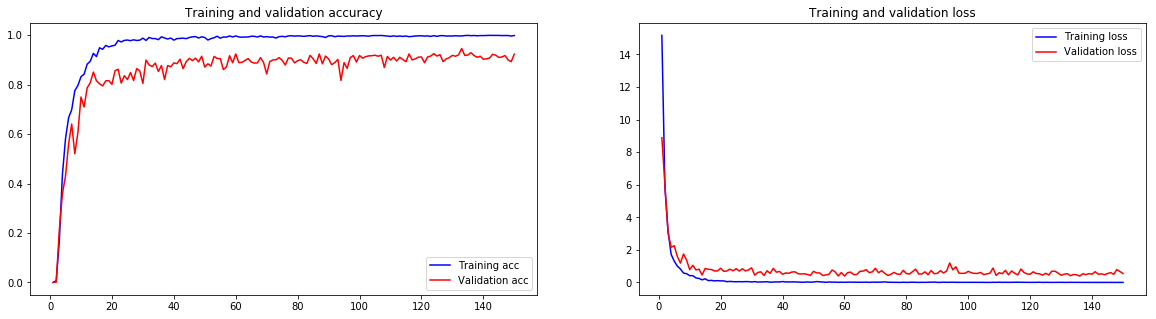

In [14]:
# To visualize the loss and accuracy behaviours of train and validation datasets
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss= history.history['val_loss']

x = [i for i in range(1, epochs +1)]
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(x, acc, 'b', label='Training acc')
plt.plot(x, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

## Model performance

In [15]:
# show the best accuracy
print('The best accuracy in train is {} and in valdation is {}'.format(np.round(max(acc),3), np.round(max(val_acc),3)))

The best accuracy in train is 0.999 and in valdation is 0.946


## Image processing and inference

In [16]:
def imageProcessing(imagePath, vizualing):
    img=cv2.imread(imagePath, 0)
    if vizualing:
        plt.imshow(img, cmap='Greys_r')
        plt.show()
    img = img[2:img.shape[0]-3, 2:img.shape[1]-3]
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    img=cv2.resize(img,(128,64))
    img=img_to_array(img)
    img = (img / 255.0) * 2.0 - 1.0
    img=np.array(img,dtype='float')
    img=np.expand_dims(img, axis=0)
    img=img.swapaxes(1,2)
    return img
    
def inference(model,imagePath, vizualing=False):
    img=imageProcessing(imagePath, vizualing)
    net_out_value = model.predict(img)
    top_pred_texts = decode_predict_ctc(net_out_value)
    result = top_pred_texts[0]
    return result

## Testing

In [17]:
#Change Paramters for inference
training = False # False for prediction
# create model
model = get_model(training,128,64,num_classes,max_text_len)
# load a model weigths
model.load_weights('models/best_weights.hdf5')

In [18]:
testFolder = "cell_images/test"
listPathsFiles = [str(path) for path in Path(testFolder).glob('*.jpg')]
listNamesFiles = [item.split('\\')[-1] for item in listPathsFiles] 
listValues = []                        
                        
                        
                        
for pathFile in listPathsFiles:
    prediction = inference(model,pathFile)
    listValues.append(prediction)
    


test_df = pd.DataFrame({'filename': listNamesFiles, 'value': listValues})

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [19]:
test_df['sortedNames'] = [int(name[:-4]) for name in test_df['filename']]
test_df = test_df.sort_values('sortedNames')
test_df = test_df.drop(['sortedNames'], axis=1)

testAnnotationPath = Path('data') / 'test.txt'
test_df.to_csv(path_or_buf=testAnnotationPath, sep=';', index=False)

## Show some results 

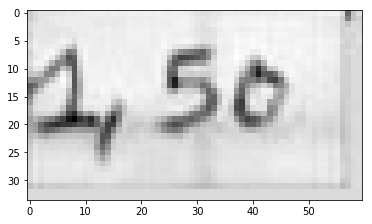

1.50


In [21]:
index = random.randint(0,len(test_df))
pathFile = 'cell_images/test/' + test_df['filename'][index]
prediction = inference(model,pathFile,vizualing=True)
print(prediction)